###Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/UNIPI/ml-query-optimization
%ls

/content/gdrive/MyDrive/UNIPI/ml-query-optimization
classification/  data/       main.py  README.md
config/          main.ipynb  models/  utils/


In [3]:
# %cd gdrive/MyDrive/UNIPI
# !git clone https://github.com/teogoulas/ml-query-optimization.git
# %cd ml-query-optimization/
# %ls

###Imports

In [4]:
!pip install gensim==4.1.2
!pip install -Uqq ipdb

     |████████████████████████████████| 24.1 MB 1.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 793 kB 4.2 MB/s 
     |████████████████████████████████| 381 kB 71.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


In [5]:
import pandas as pd
from utils.vectorization import text_vectorization
from utils.downloader import get_glove_vectors
from models.embeddings_model import EmbeddingsModel
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
import random
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
# from keras.losses import SparseCategoricalCrossentropy
# from keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import time
import pickle
from tensorflow.keras import backend as K
import ipdb
from collections import Counter

In [6]:
np.random.seed(42)

In [7]:
%pdb on

Automatic pdb calling has been turned ON


###Generate training-test data

In [8]:
def import_dataset(input_filepath: str, output_filepath: str, input_column: str, target_column: str, sep=","):
  df = pd.read_csv(input_filepath, sep=sep)
  input_data = df[[input_column]]
  print(f"Input data shape: {input_data.shape}")
  df = pd.read_csv(output_filepath, sep=sep)
  target_data = df[[target_column]].apply(lambda x : x + ' <eos>')
  print(f"Target data shape: {target_data.shape}")
  target_input_data = df[[target_column]].apply(lambda x : '<sos> '+ x)
  print(f"Target input data shape: {target_input_data.shape}")

  return input_data, target_data, target_input_data

In [9]:
input_data, target_data, target_input_data = import_dataset('data/training/input_data.csv', 'data/training/output_data.csv', 'input_queries', 'output_queries')

Input data shape: (5501, 1)
Target data shape: (5501, 1)
Target input data shape: (5501, 1)


In [10]:
raw_input_data, raw_target_data, raw_target_input_data = import_dataset('data/training/raw_input_data.csv', 'data/training/raw_output_data.csv', 'input_queries', 'output_queries', ';')

Input data shape: (5595, 1)
Target data shape: (5595, 1)
Target input data shape: (5595, 1)


In [11]:
operators_input_data, operators_target_data, operators_target_input_data = import_dataset('data/training/operators_impl_input_data_v3.csv', 'data/training/operators_impl_output_data_v3.csv', 'input_queries', 'output_queries')

Input data shape: (5445, 1)
Target data shape: (5445, 1)
Target input data shape: (5445, 1)


In [12]:
ordered_input_data, ordered_target_data, ordered_target_input_data = import_dataset('data/training/ordered_input_data_v3.csv', 'data/training/ordered_output_data_v3.csv', 'input_queries', 'output_queries')

Input data shape: (796, 1)
Target data shape: (796, 1)
Target input data shape: (796, 1)


###Vectorize inputs & outputs

In [13]:
input_vectorizer, input_corpus = text_vectorization(input_data, ['input_queries'], (1, 1))
target_vectorizer, target_corpus = text_vectorization(target_data, ['output_queries'], (1, 1))
target_input_vectorizer, target_input_corpus = text_vectorization(target_input_data, ['output_queries'], (1, 1))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk

In [14]:
print("number of input words : ", len(input_vectorizer.vocabulary_.keys()))
print("number of target words : ", len(target_vectorizer.vocabulary_.keys()))
print("number of target input words : ", len(target_input_vectorizer.vocabulary_.keys()))

number of input words :  849
number of target words :  1075
number of target input words :  1075


In [15]:
print(input_corpus[3])
print(input_data['input_queries'][3])

['join', 'model_list', '.', 'maker', 'car_makers', '.', 'id']
join model_list.maker-car_makers.id


In [16]:
raw_input_vectorizer, raw_input_corpus = text_vectorization(raw_input_data, ['input_queries'], (1, 1))
raw_target_vectorizer, raw_target_corpus = text_vectorization(raw_target_data, ['output_queries'], (1, 1))
raw_target_input_vectorizer, raw_target_input_corpus = text_vectorization(raw_target_input_data, ['output_queries'], (1, 1))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk

In [17]:
operators_input_vectorizer, operators_input_corpus = text_vectorization(operators_input_data, ['input_queries'], (1, 1))
operators_target_vectorizer, operators_target_corpus = text_vectorization(operators_target_data, ['output_queries'], (1, 1))
operators_target_input_vectorizer, operators_target_input_corpus = text_vectorization(operators_target_input_data, ['output_queries'], (1, 1))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
print("number of input words : ", len(operators_input_vectorizer.vocabulary_.keys()))
print("number of target words : ", len(operators_target_vectorizer.vocabulary_.keys()))
print("number of target input words : ", len(operators_target_input_vectorizer.vocabulary_.keys()))

print(operators_input_data['input_queries'][3])
print(operators_input_corpus[3])
print(operators_target_input_corpus[3])
print(operators_target_corpus[3])

number of input words :  766
number of target words :  9
number of target input words :  9
join model_list.maker-car_makers.id
['join', 'model_list', '.', 'maker', 'car_makers', '.', 'id']
['<sos>', 'hash_join']
['hash_join', '<eos>']


In [19]:
ordered_input_vectorizer, ordered_input_corpus = text_vectorization(ordered_input_data, ['input_queries'], (1, 1))
ordered_target_vectorizer, ordered_target_corpus = text_vectorization(ordered_target_data, ['output_queries'], (1, 1))
ordered_target_input_vectorizer, ordered_target_input_corpus = text_vectorization(ordered_target_input_data, ['output_queries'], (1, 1))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [20]:
operators_target_input_vectorizer.vocabulary_.keys()

dict_keys(['<sos>', 'hash_join', 'seq_scan', 'index_scan', 'bitmap_index_scan', 'nested_loop', 'merge_join', 'index_only_scan', 'bitmap_heap_scan'])

###Train embedding models

In [ ]:
EMBEDDING_DIM = 128

In [ ]:
# %cd data/
# !mkdir glove
# %cd glove/
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
# %cd ../../

In [ ]:
# %cd data
# !mkdir -p embedding_models
# %cd ../

In [ ]:
glove_vectors = get_glove_vectors()

In [ ]:
input_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
input_encoder.build(np.append(input_corpus, input_corpus), glove_vectors)
output_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
output_encoder.build(np.append(target_corpus, target_input_corpus, axis=0), glove_vectors)

In [ ]:
raw_input_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
raw_input_encoder.build(np.append(raw_input_corpus, raw_input_corpus), glove_vectors)
raw_output_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
raw_output_encoder.build(np.append(raw_target_corpus, raw_target_input_corpus, axis=0), glove_vectors)

In [ ]:
operators_input_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
operators_input_encoder.build(np.append(operators_input_corpus, operators_input_corpus), glove_vectors)
operators_output_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
operators_output_encoder.build(np.append(operators_target_corpus, operators_target_input_corpus, axis=0), glove_vectors)

In [ ]:
ordered_input_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
ordered_input_encoder.build(np.append(ordered_input_corpus, ordered_input_corpus), glove_vectors)
ordered_output_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM, min_count=2)
ordered_output_encoder.build(np.append(ordered_target_corpus, ordered_target_input_corpus, axis=0), glove_vectors)

###Plot Input & Output Embeddings

In [ ]:
def plot_embeddings(encoder: EmbeddingsModel, samples: int, title: str):
  vocab_size, embedding_size = encoder.model.wv.vectors.shape
  # Sample random words from model dictionary
  random_i = random.sample(range(vocab_size), samples)
  random_w = [encoder.model.wv.index_to_key[i] for i in random_i]

  # Generate Word2Vec embeddings of each word
  word_vecs = np.array([encoder.model.wv[w] for w in random_w])

  # Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
  tsne = TSNE()
  tsne_e = tsne.fit_transform(word_vecs)

  # Plot t-SNE result
  plt.figure(figsize=(32, 32))
  plt.title(title)
  plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

  for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
      plt.annotate(label,
                   xy=(x, y), xytext=(0, 15),
                   textcoords='offset points', ha='right', va='bottom',
                   bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))
  plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


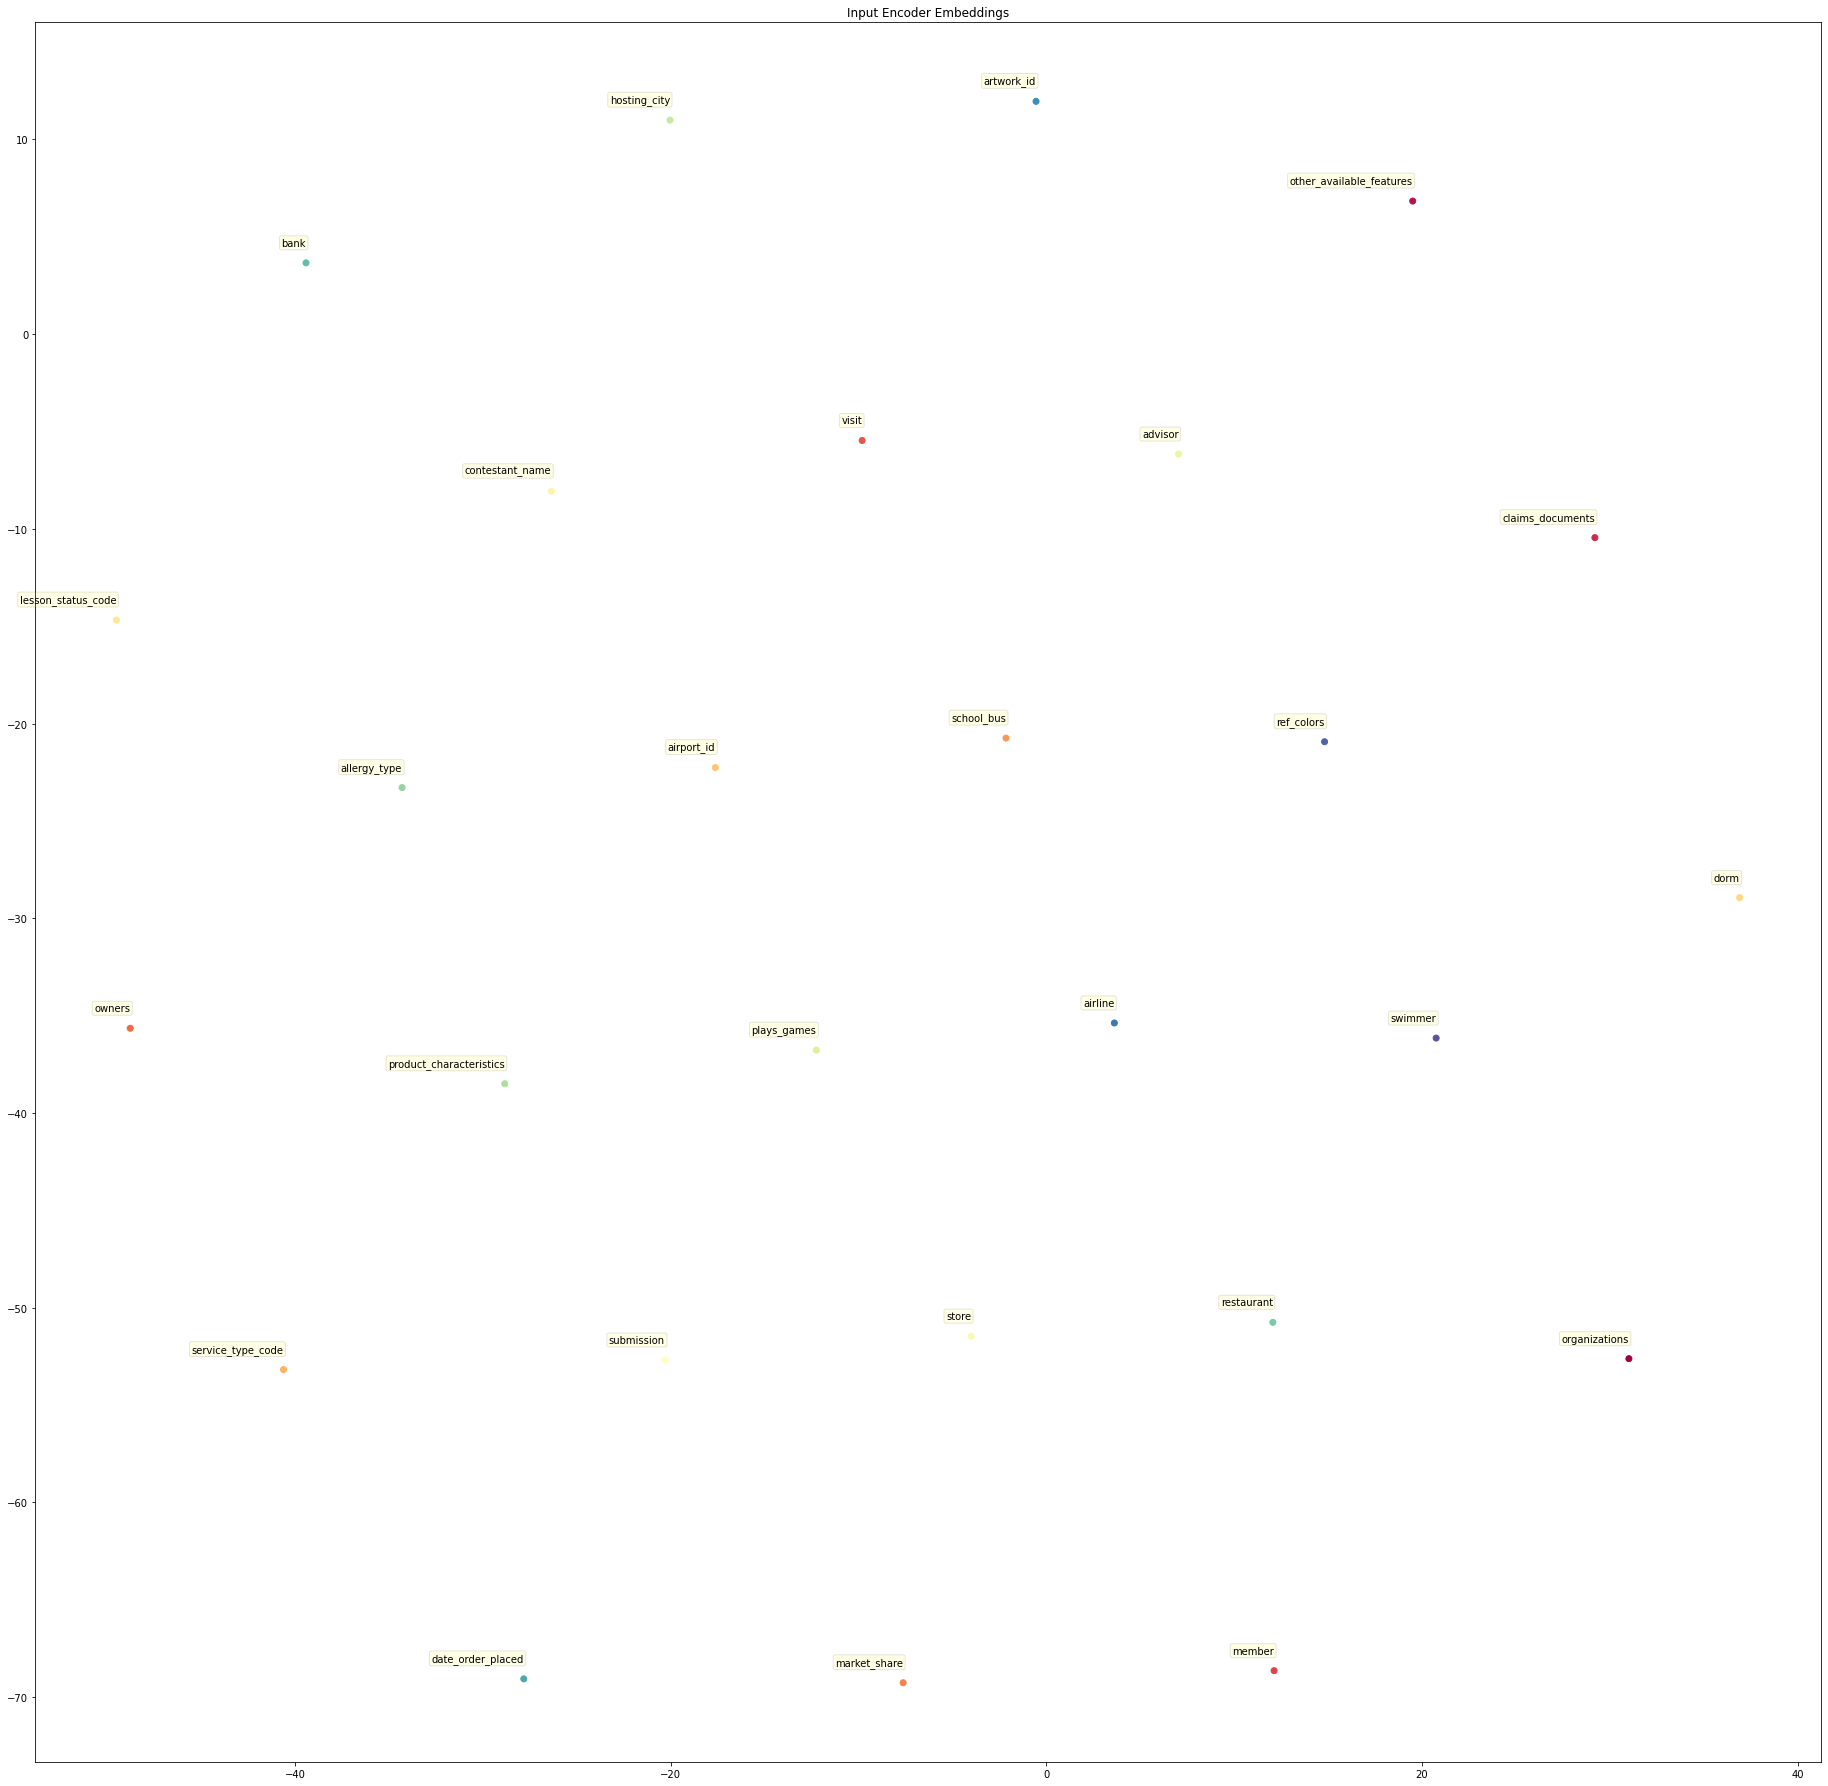

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


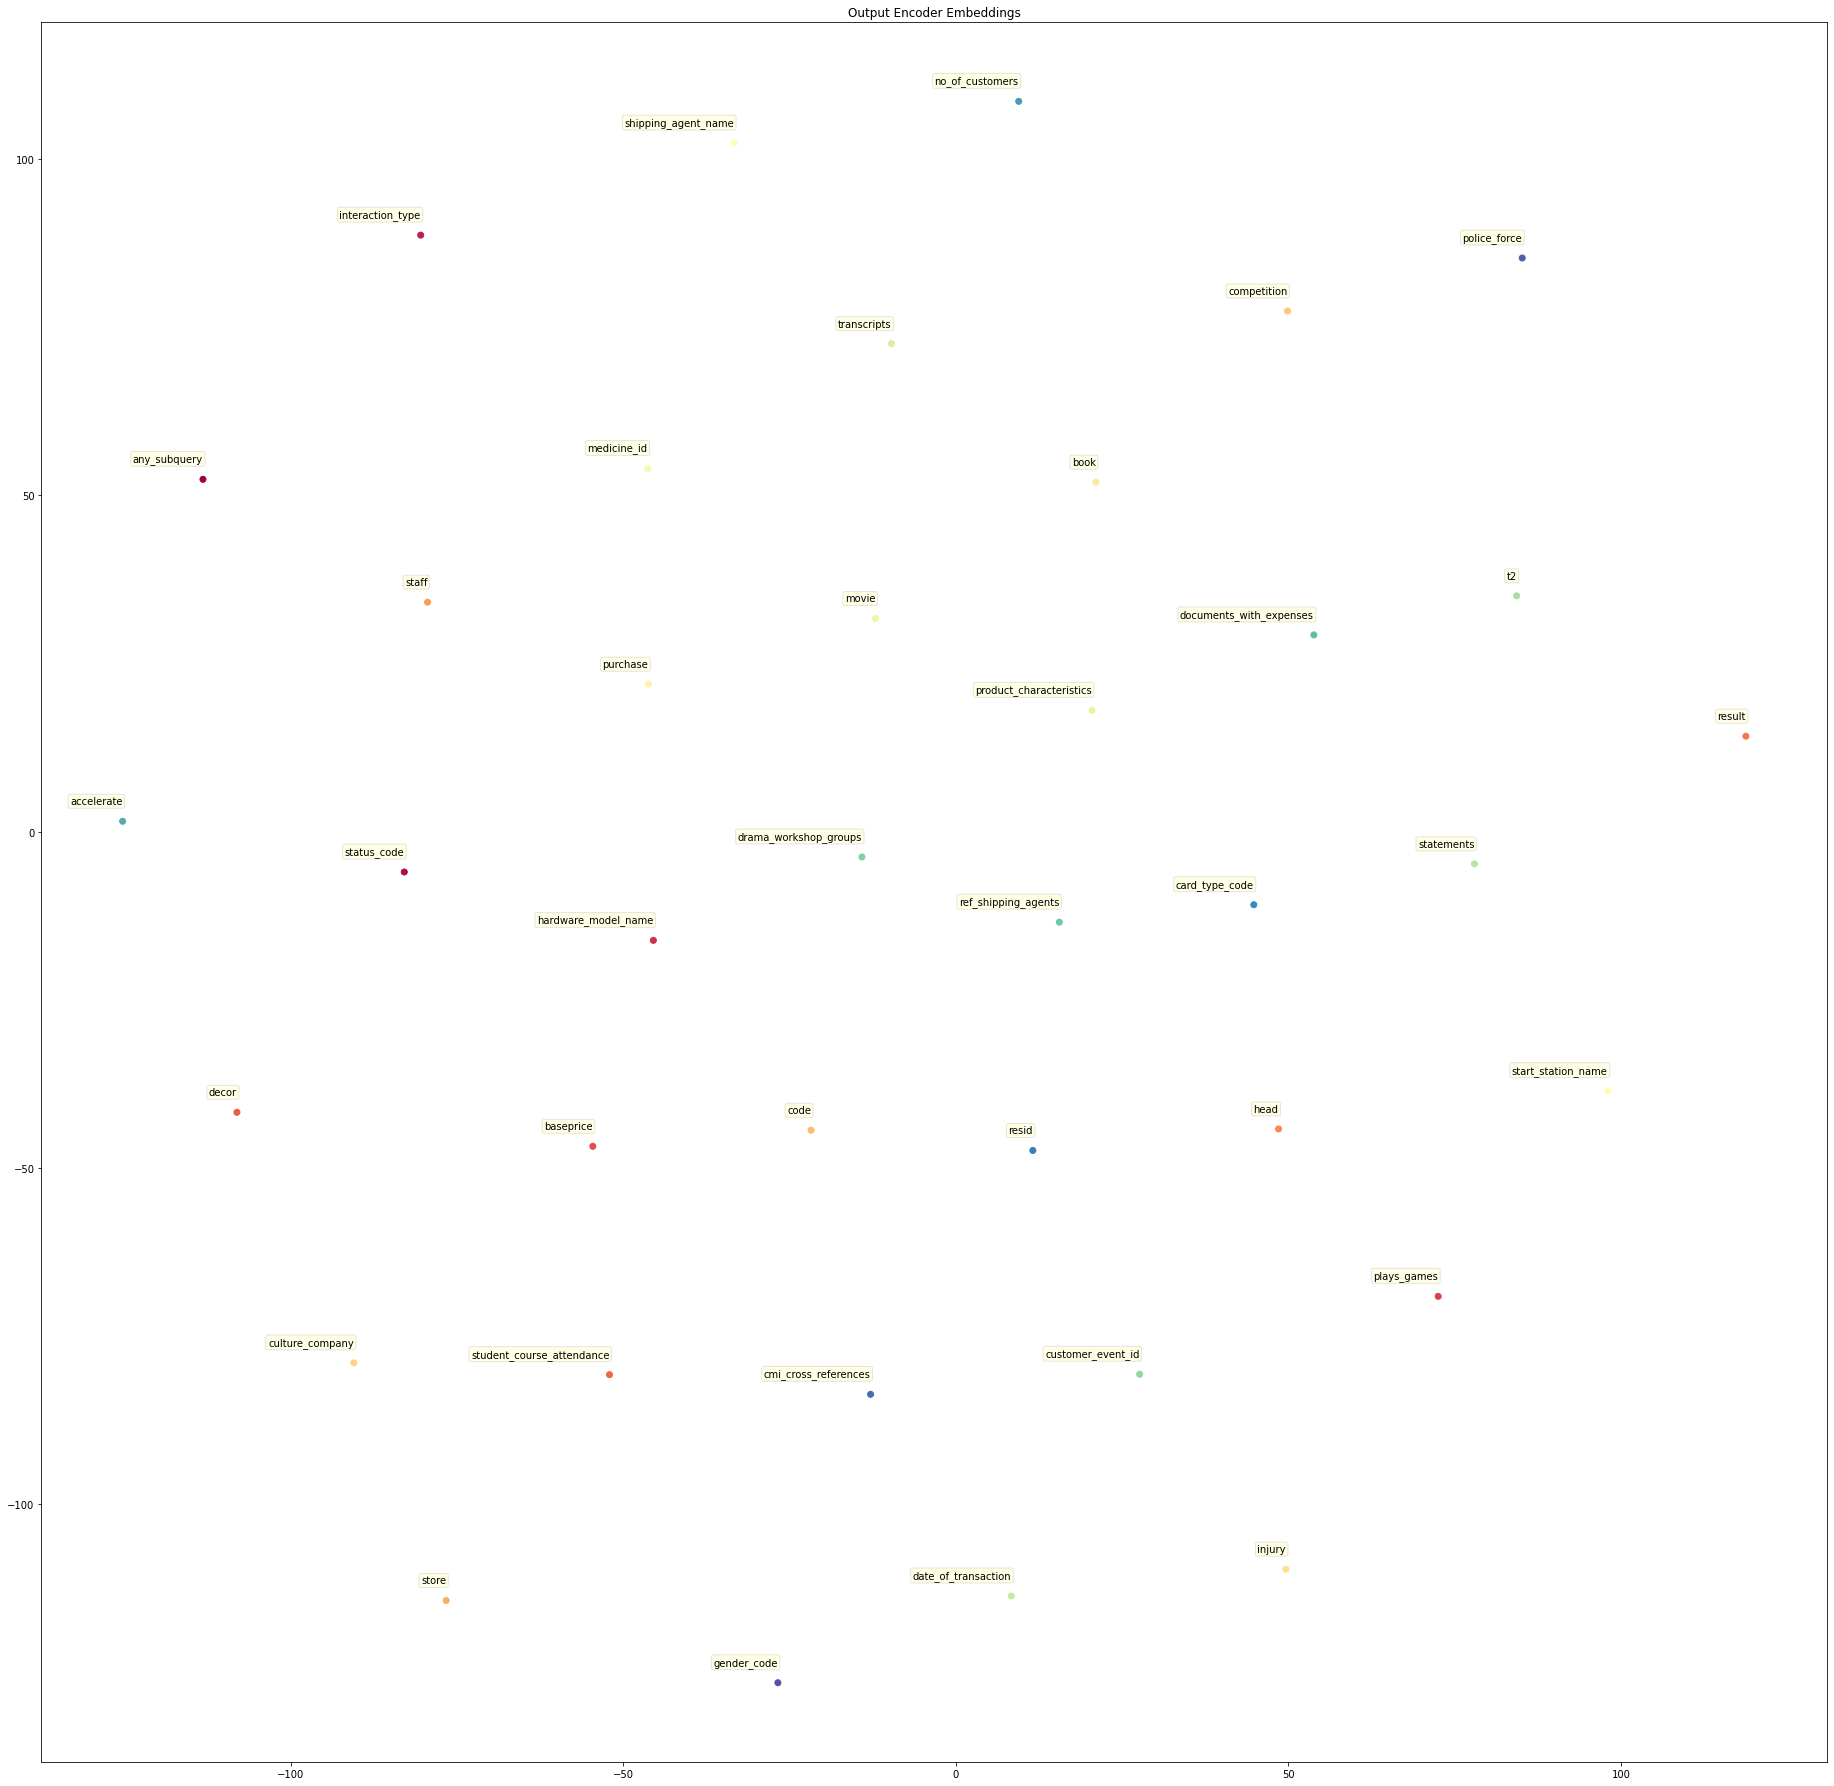

In [ ]:
plot_embeddings(input_encoder, 27, "Input Encoder Embeddings")
plot_embeddings(output_encoder, 38, "Output Encoder Embeddings")

###Save embedding models

In [ ]:
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/input_encoder'
input_encoder.model.save(filename)
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/output_encoder'
output_encoder.model.save(filename)

In [ ]:
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_input_encoder'
raw_input_encoder.model.save(filename)
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_output_encoder'
raw_output_encoder.model.save(filename)

In [ ]:
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_input_encoder'
operators_input_encoder.model.save(filename)
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_output_encoder'
operators_output_encoder.model.save(filename)

In [ ]:
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/ordered_input_encoder'
ordered_input_encoder.model.save(filename)
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/ordered_output_encoder'
ordered_output_encoder.model.save(filename)

###Tokenize inputs & outputs 

In [21]:
def texts2sequences(texts: np.array, vocab: dict):
  sequences = []
  for i, text in enumerate(texts):
    seq = []
    for token in text:
      if token in vocab.keys():
        seq.append(vocab[token])
      # else:
      #   print(f"token: {token} not found at text: {text} in position: {i}!")
    sequences.append(seq)

  return sequences

In [22]:
def pad_tokenizer(x: np.array, vocab: dict, zero_padding=True):
  # tokenize input
  #tokenizer_obj = Tokenizer()
  #tokenizer_obj.fit_on_texts(x)
  sequences = texts2sequences(x, vocab)

  # pad sequences
  max_length = max([len(s) for s in x])
  vocab_size = len(vocab)
  print('Found %s unique tokens.' % vocab_size)

  train_pad = pad_sequences(sequences, maxlen=max_length, padding='post', value=0 if zero_padding else vocab_size)
  
  return max_length, train_pad

In [23]:
def pad_tokenizer_bow(input_data: np.array, target_input_data=None, vocab_size=20000):

  # Create a tokenizer for the input texts and fit it to them 
  tokenizer = Tokenizer(num_words=vocab_size, filters='')
  tokenizer.fit_on_texts(input_data)
  
  if target_input_data is not None:
    tokenizer.fit_on_texts(target_input_data)
    target_input_sequences = tokenizer.texts_to_sequences(target_input_data)
  else:
    target_input_sequences = None

  # Tokenize and transform input texts to sequence of integers
  input_sequences = tokenizer.texts_to_sequences(input_data)
  # Claculate the max length
  input_max_len = max(len(s) for s in input_sequences)
  print('Max Input Length: ', input_max_len)

  tokenizer.word_index['<empty>'] = 0
  # get the word to index mapping for input language
  word2idx = tokenizer.word_index
  print('Found %s unique input tokens.' % len(word2idx))

  num_words = len(word2idx) + 1
  idx2word = {v:k for k, v in word2idx.items()}

  padded_input_sequences = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
  if target_input_sequences is not None:
    padded_input_target_sequences = pad_sequences(target_input_sequences, maxlen=input_max_len, padding='post')
  else:
    padded_input_target_sequences = None

  print("padded sequences shape:", padded_input_sequences.shape)

  return input_max_len, padded_input_sequences, tokenizer, idx2word, padded_input_target_sequences

###Build model

In [24]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024
BATCH_SIZE = 16
EPOCHS = 100
LOG_EVERY = 50
PATIENCE = 5
WAIT = 0
BEST = np.Inf
ENCODER_BEST_WEIGHTS = None
DECODER_BEST_WEIGHTS = None
BEST_EPOCH = 0
STOPPED_EPOCH = 0

In [25]:
def get_embedding_matrix(vocab, embeddings_index, embedding_dim=EMBEDDING_DIM):
  embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
  for word, i in vocab.items():
    if word in embeddings_index.index_to_key:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embeddings_index[word]
  return embedding_matrix

In [26]:
def create_glove_datasets(input_corpus, target_input_corpus, target_corpus, input_encoder, output_encoder):

  input = input_corpus
  target = np.column_stack((target_input_corpus, target_corpus))

  print(f"Input shape: {input.shape}, Target shape: {input.shape}")

  y_train, y_test, input_train, input_test = train_test_split(target, input, test_size=0.1, random_state=42)
  target_input_train = y_train[:,0]
  target_train = y_train[:,1]
  target_input_test = y_test[:,0]
  target_test = y_test[:,1]

  print(f"Input train shape: {input_train.shape}, target train shape: {target_train.shape}, target input train shape: {target_input_train.shape}")
  print(f"Input test shape: {input_test.shape}, target test shape: {target_test.shape}, target input test shape: {target_input_test.shape}")

  x_max_length, encoder_inputs = pad_tokenizer(input_train, input_encoder.model.wv.key_to_index, False)
  y_max_length, decoder_targets = pad_tokenizer(target_train, output_encoder.model.wv.key_to_index, False)
  _, decoder_inputs = pad_tokenizer(target_input_train, output_encoder.model.wv.key_to_index, False)

  dec_inputs = np.column_stack((decoder_inputs, decoder_targets))
  dec_train, dec_val, train_encoder_inputs, val_encoder_inputs = train_test_split(dec_inputs, encoder_inputs, test_size=0.2, random_state=42)
  train_decoder_inputs = dec_train[:,:y_max_length]
  train_decoder_targets = dec_train[:,y_max_length:]
  val_decoder_inputs = dec_val[:,:y_max_length]
  val_decoder_targets = dec_val[:,y_max_length:]

  print(f"Encoder Input train shape: {train_encoder_inputs.shape}, Decoder input train shape: {train_decoder_inputs.shape}, Decoder target train shape: {train_decoder_targets.shape}")
  print(f"Encoder Input validation shape: {val_encoder_inputs.shape}, Decoder validation train shape: {val_decoder_inputs.shape}, Decoder validation train shape: {val_decoder_targets.shape}")

  return train_encoder_inputs, train_decoder_inputs, train_decoder_targets, val_encoder_inputs, val_decoder_inputs, val_decoder_targets, input_test, target_test, x_max_length, y_max_length

In [27]:
def create_bow_datasets(input_corpus, target_input_corpus, target_corpus):
  input = input_corpus
  target = np.column_stack((target_input_corpus, target_corpus))

  print(f"Input shape: {input.shape}, Target shape: {input.shape}")

  y_train, y_test, input_train, input_test = train_test_split(target, input, test_size=0.1, random_state=42)
  target_input_train = y_train[:,0]
  target_train = y_train[:,1]
  target_input_test = y_test[:,0]
  target_test = y_test[:,1]

  print(f"Input train shape: {input_train.shape}, target train shape: {target_train.shape}, target input train shape: {target_input_train.shape}")
  print(f"Input test shape: {input_test.shape}, target test shape: {target_test.shape}, target input test shape: {target_input_test.shape}")

  x_max_length, encoder_inputs, input_tokenizer, idx2word_input, _ = pad_tokenizer_bow(input_train)
  y_max_length, decoder_targets, output_tokenizer, idx2word_output, decoder_inputs = pad_tokenizer_bow(target_train, target_input_train)

  dec_inputs = np.column_stack((decoder_inputs, decoder_targets))
  dec_train, dec_val, train_encoder_inputs, val_encoder_inputs = train_test_split(dec_inputs, encoder_inputs, test_size=0.2, random_state=42)
  train_decoder_inputs = dec_train[:,:y_max_length]
  train_decoder_targets = dec_train[:,y_max_length:]
  val_decoder_inputs = dec_val[:,:y_max_length]
  val_decoder_targets = dec_val[:,y_max_length:]

  print(f"Encoder Input train shape: {train_encoder_inputs.shape}, Decoder input train shape: {train_decoder_inputs.shape}, Decoder target train shape: {train_decoder_targets.shape}")
  print(f"Encoder Input validation shape: {val_encoder_inputs.shape}, Decoder validation train shape: {val_decoder_inputs.shape}, Decoder validation train shape: {val_decoder_targets.shape}")
  
  return train_encoder_inputs, train_decoder_inputs, train_decoder_targets, val_encoder_inputs, val_decoder_inputs, val_decoder_targets, input_test, target_test, x_max_length, y_max_length, input_tokenizer, idx2word_input, output_tokenizer, idx2word_output

In [28]:
class Encoder(Model):
    def __init__(self, vocab_size, max_length, embedding_matrix=[], num_hidden=HIDDEN_DIM, num_embedding=EMBEDDING_DIM, batch_size=BATCH_SIZE, pretrained_embeddings=True):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.num_hidden = num_hidden
        self.num_embedding = num_embedding
        self.embedding = Embedding(vocab_size, num_embedding, input_length=max_length, weights=[embedding_matrix], trainable=False) if pretrained_embeddings else Embedding(vocab_size, num_embedding, input_length=max_length)
        self.lstm = LSTM(num_hidden, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                    return_state=True)
        
    def call(self, input_sequence, states):
        embedded = self.embedding(input_sequence) #converts integer tokens into a dense representation
        # print(f"embedded shape = {embedded.shape}")
        # print(f"hidden shape = {hidden.shape}")
        output, state_h, state_c = self.lstm(embedded, initial_state=states)
        # print(f"rnn_out shape = {rnn_out.shape}")
        # print(f"hidden shape = {hidden.shape}")
        return output, state_h, state_c

    def init_hidden(self, batch_size=None):
        if batch_size is None:
          batch_size = self.batch_size 
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.num_hidden]),
                tf.zeros([batch_size, self.num_hidden]))

In [29]:
class LuongAttention(Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)
        
    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score)
        alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
        
        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)

        return context, alignment

In [30]:
class Decoder(Model):
    def __init__(self, vocab_size, max_length, embedding_matrix=[], attention_func='concat', hidden_dim=HIDDEN_DIM, num_embedding=EMBEDDING_DIM, batch_size=BATCH_SIZE, pretrained_embeddings=True):
        super(Decoder, self).__init__()
        
        self.attn = LuongAttention(hidden_dim, attention_func)
        self.embedding = Embedding(vocab_size, num_embedding, input_length=max_length, weights=[embedding_matrix], trainable=False) if pretrained_embeddings else Embedding(vocab_size, num_embedding, input_length=max_length)
        self.lstm = LSTM(hidden_dim, recurrent_initializer='glorot_uniform',
                                   return_sequences=True, return_state=True)
        self.fc = Dense(hidden_dim, activation='tanh')
        self.fs = Dense(vocab_size)
        
    def call(self, input_sequence, state, encoder_output):
        # ipdb.set_trace()
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(input_sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attn to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, hidden_dim)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attn(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, hidden_dim),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.fc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.fs(lstm_out)

        return logits, state_h, state_c, alignment

In [31]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# # train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
# val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# #val_loss_metric = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [32]:
def loss_func(targets, logits, padding_value=0):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, padding_value))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred, training=True, padding_value=0):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    # ipdb.set_trace()
    pred_values = K.cast(K.argmax(y_pred, axis=-1) if training else y_pred, dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    if padding_value == 0:
      mask = K.cast(K.greater(y_true, padding_value), dtype='float32')
    else:
      mask = K.cast(K.less(y_true, padding_value), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [33]:
def train_step(input_tensor, target_seq_in, target_seq_out, enc_hidden, encoder, decoder, optimizer, padding_value=0):
    loss = 0.0
    acc = 0.0
    logits = None

    with tf.GradientTape() as tape:
        enc_output, de_state_h, de_state_c = encoder(input_tensor, enc_hidden)
        # cur_time = time.time() - time_taken
        # print("Time taken to get encoder outputs: %.2fs" % (cur_time))
        # ipdb.set_trace()
        for tx in range(target_seq_out.shape[1]):
            # ipdb.set_trace()
            decoder_in = tf.expand_dims(target_seq_in[:, tx], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c),
                                            enc_output)
            # cur_time = time.time() - time_taken - cur_time
            # print("Time taken to get decoder outputs: %.2fs" % (cur_time))
            loss += loss_func(target_seq_out[:, tx], logit, padding_value)
            # cur_time = time.time() - time_taken - cur_time
            # print("Time taken to calculate loss: %.2fs" % (cur_time))
            # Store the logits to calculate the accuracy
            logit = K.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1)
        
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits, True, padding_value)
        # cur_time = time.time() - time_taken - cur_time
        # print("Time taken to calculate total accuracy: %.2fs" % (cur_time))

    batch_loss = loss / target_seq_out.shape[1]
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    # cur_time = time.time() - time_taken - cur_time
    # print("Time taken to calculate gradients: %.2fs" % (cur_time))
    return batch_loss, acc

In [34]:
def test_step(input_tensor, target_seq_in, target_seq_out, enc_hidden, encoder, decoder, padding_value=0): #input_tensor, target_tensor, enc_hidden, encoder, decoder 
  loss = 0.0
  accuracy = 0.0
  logits = None
  enc_output, de_state_h, de_state_c = encoder(input_tensor, enc_hidden)
  # ipdb.set_trace()
  for tx in range(target_seq_out.shape[1]):
      # ipdb.set_trace()
      decoder_in = tf.expand_dims(target_seq_in[:, tx], 1)
      logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c),
                                      enc_output)
      loss += loss_func(target_seq_out[:, tx], logit, padding_value)
      # Store the logits to calculate the accuracy
      logit = K.expand_dims(logit, axis=1)
      if logits is None:
          logits = logit
      else:
          logits = K.concatenate((logits,logit), axis=1)
  acc = accuracy_fn(target_seq_out, logits, True, padding_value)
      

  batch_loss = loss / target_seq_out.shape[1]

  return batch_loss, acc

In [35]:
def main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_outputs,
               val_encoder_inputs, val_decoder_inputs, val_decoder_outputs,
               input_encoder, x_max_length, output_encoder, y_max_length, checkpoint_dir, results_dir,
               pretrained_embeddings=True, idx2word_input={}, idx2word_output={},
               epochs=EPOCHS, log_every=LOG_EVERY, best=BEST, best_epoch=BEST_EPOCH, encoder_best_weights=ENCODER_BEST_WEIGHTS,
               decoder_best_weights=DECODER_BEST_WEIGHTS, wait=WAIT, patience=PATIENCE, stopped_epoch=STOPPED_EPOCH,
               num_hidden=HIDDEN_DIM, batch_size=BATCH_SIZE, attention_func='general'):
  
  buffer_size = len(train_encoder_inputs)
  dataset = tf.data.Dataset.from_tensor_slices((train_encoder_inputs, train_decoder_inputs, train_decoder_outputs)).shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  steps_per_epoch = buffer_size // batch_size

  buffer_size_val = len(val_encoder_inputs)
  dataset_val = tf.data.Dataset.from_tensor_slices((val_encoder_inputs, val_decoder_inputs, val_decoder_outputs)).shuffle(buffer_size_val)
  dataset_val = dataset_val.batch(batch_size)
  steps_per_epoch_val = buffer_size_val // batch_size

  if pretrained_embeddings:
    en_vocab_size = len(input_encoder.model.wv.key_to_index) + 1
    en_embedding_matrix = get_embedding_matrix(input_encoder.model.wv.key_to_index, input_encoder.model.wv)

    dec_vocab_size = len(output_encoder.model.wv.key_to_index) + 1
    dec_embedding_matrix = get_embedding_matrix(output_encoder.model.wv.key_to_index, output_encoder.model.wv)
    padding_value = len(output_encoder.model.wv.key_to_index)
  else:
    en_vocab_size = len(input_encoder.word_index)
    en_embedding_matrix = []

    dec_vocab_size = len(output_encoder.word_index)
    dec_embedding_matrix = []
    padding_value = 0

  encoder = Encoder(en_vocab_size, x_max_length, en_embedding_matrix, num_hidden, EMBEDDING_DIM, batch_size, pretrained_embeddings) #embedding_matrix=[], num_hidden=256, num_embedding=EMBEDDING_DIM, batch_size=16, pretrained_embeddings=True
  decoder = Decoder(dec_vocab_size, y_max_length, dec_embedding_matrix, 'general', num_hidden, EMBEDDING_DIM, batch_size, pretrained_embeddings)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  time_per_epoch = []

  optimizer = Adam(0.005)
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

  for e in range(1, epochs):
    start_time = time.time()
    # print("Start Time: %.2fs" % (start_time))
    total_loss = 0.0
    total_accuracy = 0.0
    enc_hidden = encoder.init_hidden(batch_size)
    #cur_time = time.time() - start_time
    # print("Encoder init time: %.2fs" % (cur_time))

    for idx, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(steps_per_epoch)):
        # print("idx: {0}, input_tensor shape: {1}, target_tensor shape: {2}".format(idx, input_tensor.shape,
        #                                                                            output_tensor.shape))
        # ipdb.set_trace()
        batch_loss, batch_accuracy = train_step(input_seq, target_seq_in, target_seq_out, enc_hidden, encoder, decoder, optimizer, padding_value)
        #cur_time = time.time() - start_time - cur_time
        #print("Training batch time: %.2fs" % (cur_time))
        total_loss += batch_loss
        total_accuracy += batch_accuracy

        if idx % log_every == 0:
            print("Epochs: {} batch {}/{} | batch_accuracy: {:.4f} | batch_loss: {:.4f}".format(e, idx, steps_per_epoch, batch_accuracy, batch_loss))

    train_acc = total_accuracy / steps_per_epoch
    train_accuracies.append(train_acc)
    train_loss = total_loss / steps_per_epoch
    train_losses.append(train_loss)
    print("Epoch: {} | Training accuracy over epoch: {:.4f} | Training loss over epoch: {:.4f}".format(e, float(train_acc), float(train_loss)))

    total_loss = 0.0
    total_accuracy = 0.0
    for idx, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset_val.take(steps_per_epoch_val)):
      batch_loss, batch_accuracy = test_step(input_seq, target_seq_in, target_seq_out, enc_hidden, encoder, decoder, padding_value)
      total_loss += batch_loss
      total_accuracy += batch_accuracy
    
    # cur_time = time.time() - start_time - cur_time
    # print("Validation time: %.2fs" % (cur_time))

    val_acc = total_accuracy / steps_per_epoch_val
    val_accuracies.append(val_acc)
    val_loss = total_loss / steps_per_epoch_val
    val_losses.append(val_loss)
    epoch_time = time.time() - start_time
    time_per_epoch.append(epoch_time)
    print("Epoch: {} | Validation acc: {:.4f} | Validation loss: {:.4f}".format(e, float(val_acc), float(val_loss)))
    print("Time taken: %.2fs" % (epoch_time))

    # if e % 2 == 0:
        # print("Epochs: {}/{} | total_loss: {:.4f} | total_accuracy: {:.4f}".format(
        #     e, EPOCHS, total_loss / steps_per_epoch, total_accuracy / steps_per_epoch))
    #    print("Epochs: {}/{} | total_loss: {:.4f}".format(e, EPOCHS, total_loss / steps_per_epoch))
    
    # The early stopping strategy: stop the training if `val_loss` does not
    # decrease over a certain number of epochs.
    
    if np.less(val_loss, best):
      best = val_loss
      wait = 0
      best_epoch = e
      # Record the best weights if current results is better (less).
      encoder_best_weights = encoder.get_weights()
      decoder_best_weights = decoder.get_weights()
    else:
      wait += 1
      if wait >= patience:
        stopped_epoch = e
        encoder.stop_training = True
        decoder.stop_training = True
        print(f"Early stopping activated! Restoring model weights from the end of the (best) epoch: {best_epoch}.")
        encoder.set_weights(encoder_best_weights)
        decoder.set_weights(decoder_best_weights)
        checkpoint.save(file_prefix = checkpoint_prefix)
        break

  if encoder.stop_training or decoder.stop_training:
    encoder.set_weights(encoder_best_weights)
    decoder.set_weights(decoder_best_weights)
  checkpoint.save(file_prefix = checkpoint_prefix)

  with open(results_dir, "wb") as f:
    results = {
      'train_losses': train_losses, 
      'train_accuracies': train_accuracies, 
      'val_losses': val_losses, 
      'val_accuracies': val_accuracies,
      'time_per_epoch': time_per_epoch
    }
    pickle.dump(results, f)
  
  return encoder, decoder, results


### Results

In [36]:
def plot_results(results_dir):
  with open(results_dir, "rb") as f:
    results = pickle.load(f)

  train_losses = [float(loss) for loss in results['train_losses']]
  train_accuracies = [float(loss) for loss in results['train_accuracies']]
  val_losses = [float(loss) for loss in results['val_losses']]
  val_accuracies = [float(loss) for loss in results['val_accuracies']]
  time_per_epoch = [float(loss) for loss in results['time_per_epoch']]

  print("Total training time: %.2fs" % (sum(time_per_epoch)))
  print("Average time per epoch: %.2fs" % (sum(time_per_epoch)/len(time_per_epoch)))

  epoches = [i+1 for i in range(len(train_losses))]
  fig1, ax1 = plt.subplots()

  ax1.plot(epoches, train_losses, color="C0", label='train')
  ax1.plot(epoches, val_losses, color="C1", label='validation')

  ax1.grid(which="major", axis="both")
  ax1.set_ylabel("loss")
  ax1.set_xlabel("epoch")
  ax1.set_xticks(epoches)
  ax1.set_title('Loss')
  ax1.legend()

  fig1.show()

  fig2, ax2 = plt.subplots()

  ax2.plot(epoches, train_accuracies, color="C0", label='train')
  ax2.plot(epoches, val_accuracies, color="C1", label='validation')

  ax2.grid(which="major", axis="both")
  ax2.set_ylabel("accuracy")
  ax2.set_xlabel("epoch")
  ax2.set_xticks(epoches)
  ax2.set_title('Accuracy')
  ax2.legend()

  fig2.show()

In [70]:
def plot_test_accuracy(bsl_test_acc, bsl_total_acc, test_acc, total_acc):
  x = [str(i) + (' operator' if i < 2 else ' operators') for i in test_acc.keys()]
  x.append('overall')
  X_axis = np.arange(len(x))

  bsl_y = [float(i) for i in bsl_test_acc.values()]
  bsl_y.append(bsl_total_acc)
  y = [float(i) for i in test_acc.values()]
  y.append(total_acc)


  plt.bar(X_axis - 0.2, y, 0.4, color="C0", label='Model')
  plt.bar(X_axis + 0.2, bsl_y, 0.4, color="C1", label='Baseline model')

  plt.xticks(X_axis, x)
  plt.grid(which="major", axis="both")
  plt.xlabel("Accuracy score (%)")
  plt.ylabel("Samples complexity")
  plt.title('Accuracy per sample complexity')
  plt.legend(loc='upper right')

  plt.show()

###Predict - Inference model

In [38]:
from sklearn.metrics import accuracy_score

def predict_seq2seq_att(input_text, input_max_len, input_encoder, output_encoder, encoder, decoder, output_text, output_max_len, baseline_model_choice, idx2word_outputs={}, pretrained_embeddings=True):
    print(input_text)
    
    padding_value = len(input_encoder.model.wv.key_to_index) if pretrained_embeddings else 0
    # print(output_text)
    # Tokenize the input text
    # print(f"pretrained_embeddings: {pretrained_embeddings}")
    input_seq = texts2sequences([input_text], input_encoder.model.wv.key_to_index) if pretrained_embeddings else input_encoder.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post', value=padding_value)
    # input_seq = input_text
    # Get the encoder initial states
    en_initial_states = encoder.init_hidden(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    idx = output_encoder.model.wv.key_to_index['<sos>'] if pretrained_embeddings else output_encoder.word_index['<sos>']
    de_input = tf.constant([[idx]])
    # Get baseline model characters codes
    bsl_idx = output_encoder.model.wv.key_to_index[baseline_model_choice] if pretrained_embeddings else output_encoder.word_index[baseline_model_choice]
    eos_idx = output_encoder.model.wv.key_to_index['<eos>'] if pretrained_embeddings else output_encoder.word_index['<eos>']
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]


    bsl_out_words = []
    bsl_out_sequence = []
    out_words = []
    out_sequence = []
    alignments = []
    # ipdb.set_trace()
    # prediction_length = None if pretrained_embeddings else output_text.count('scan') + output_text.count('join')
    while True:
        # Get the decoder with attention output
        # ipdb.set_trace()
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        word = output_encoder.model.wv.index_to_key[de_input.numpy()[0][0]] if pretrained_embeddings else idx2word_outputs[de_input.numpy()[0][0]]
        out_words.append(word)
        out_sequence.append(de_input.numpy()[0][0])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if word == '<eos>' or len(out_words) >= output_max_len:
          bsl_out_words.append('<eos>')
          break

        bsl_out_words.append(baseline_model_choice)
        bsl_out_sequence.append(bsl_idx)
        # elif not pretrained_embeddings and len(out_words) >= prediction_length:
        #   out_words.append('<eos>')
        #   out_sequence.append(output_encoder.word_index['<eos>'])
        #   break

    # Join the output words
    # ipdb.set_trace()
    if pretrained_embeddings:
      padding_value = len(output_encoder.model.wv.key_to_index)
      bsl_padded_out = pad_sequences([[padding_value if item == eos_idx else item for item in bsl_out_sequence]], maxlen=output_max_len, padding='post', value=padding_value)[0]
      padded_out = pad_sequences([[padding_value if item == eos_idx else item for item in out_sequence]], maxlen=output_max_len, padding='post', value=padding_value)[0]
      output_seq = texts2sequences([output_text], output_encoder.model.wv.key_to_index)
    else:
      bsl_padded_out = pad_sequences([[padding_value if item == eos_idx else item for item in bsl_out_sequence]], maxlen=output_max_len, padding='post', value=padding_value)[0]
      padded_out = pad_sequences([[padding_value if item == eos_idx else item for item in out_sequence]], maxlen=output_max_len, padding='post', value=padding_value)[0]
      output_seq = output_encoder.texts_to_sequences([output_text])
    # padded_out = pad_sequences([out_sequence], maxlen=output_max_len, padding='post')[0]

    # output_seq = texts2sequences([output_text], output_encoder.model.wv.key_to_index) if pretrained_embeddings else output_encoder.texts_to_sequences([output_text])
    # Pad the sentence
    # output_seq = pad_sequences(output_seq, maxlen=output_max_len, padding='post')[0]
    # acc = accuracy_score(output_seq, out_sequence)
    output_seq = pad_sequences([[padding_value if item == eos_idx else item for item in output_seq[0]]], maxlen=output_max_len, padding='post', value=padding_value)[0]
    bsl_acc = accuracy_fn(output_seq, bsl_padded_out, False, padding_value)
    acc = accuracy_fn(output_seq, padded_out, False, padding_value)

    return np.array(alignments), input_text, bsl_out_words, bsl_acc, out_words, acc

In [39]:
def generate_predictions(X_test, y_test, input_encoder, output_encoder, checkpoint_dir, x_test_max_length, y_test_max_length,
                         idx2word_input=None, idx2word_output=None, pretrained_embeddings=True, num_hidden=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, batch_size=BATCH_SIZE, baseline_model='MOST_COMMON'):
  # tokenize input
  print(x_test_max_length)
  print(y_test_max_length)

  predict_optimizer = tf.keras.optimizers.Adam(0.005)

  if pretrained_embeddings:
    en_vocab_size = len(input_encoder.model.wv.key_to_index) + 1
    en_embedding_matrix = get_embedding_matrix(input_encoder.model.wv.key_to_index, input_encoder.model.wv)

    dec_vocab_size = len(output_encoder.model.wv.key_to_index) + 1
    dec_embedding_matrix = get_embedding_matrix(output_encoder.model.wv.key_to_index, output_encoder.model.wv)
  else:
    en_vocab_size = len(input_encoder.word_index)
    en_embedding_matrix = []

    dec_vocab_size = len(output_encoder.word_index)
    dec_embedding_matrix = []

  encoder = Encoder(en_vocab_size, x_max_length, en_embedding_matrix, num_hidden, embedding_dim, batch_size, pretrained_embeddings) #embedding_matrix=[], num_hidden=256, num_embedding=EMBEDDING_DIM, batch_size=16, pretrained_embeddings=True
  decoder = Decoder(dec_vocab_size, y_max_length, dec_embedding_matrix, 'general', num_hidden, embedding_dim, batch_size, pretrained_embeddings)

  # encoder = Encoder(len(input_encoder.model.wv.key_to_index if pretrained_embeddings else idx2word_input) + 1, x_test_max_length, get_embedding_matrix(input_encoder.model.wv.key_to_index, input_encoder.model.wv) if pretrained_embeddings else [], 256, EMBEDDING_DIM, 16, pretrained_embeddings)
  # decoder = Decoder(len(output_encoder.model.wv.key_to_index if pretrained_embeddings else idx2word_output) + 1, y_test_max_length, get_embedding_matrix(output_encoder.model.wv.key_to_index, output_encoder.model.wv) if pretrained_embeddings else [], 'concat', 256, EMBEDDING_DIM, 16, pretrained_embeddings)

  checkpoint = tf.train.Checkpoint(optimizer=predict_optimizer,
                                  encoder=encoder,
                                  decoder=decoder)

  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  test_sents = list(X_test)#[0:(0+n_predictions)]
  # ipdb.set_trace()
  # Create the figure to plot in
  # fig = plt.figure(figsize=(10, 20))
  most_common_choice = y_test[0][0]
  most_common_choices = Counter([item for sublist in y_test for item in sublist]).most_common(2)
  for token, count in most_common_choices:
    if token != '<eos>':
      most_common_choice = token
      break

  total_acc = 0.0
  total_baseline_acc = 0.0
  for i, test_sent in enumerate(test_sents):
      # Call the predict function to get the translation
      baseline_model_choice = most_common_choice if baseline_model == 'MOST_COMMON' else y_test[i][0]

      alignments, source, bsl_prediction, bsl_acc, prediction, acc = predict_seq2seq_att(test_sent, x_test_max_length, input_encoder, output_encoder, encoder, decoder, y_test[i], y_test_max_length, baseline_model_choice, idx2word_output, pretrained_embeddings)
      print(f"baseline model prediction: {bsl_prediction}")
      print(f"model prediction: {prediction}")
      print(f"actual: {y_test[i]}")
      print(f"Model Accuracy: {acc}")
      print(f"Baseline model Accuracy: {bsl_acc}\n")
      total_acc += acc
      total_baseline_acc += bsl_acc
      # attention = np.squeeze(alignments, (1, 2))
      # Create a subplot
      # ax = fig.add_subplot(1, n_predictions, i+1)
      # ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
      # ax.set_xticklabels([''] + source, rotation=90)
      # ax.set_yticklabels([''] + prediction)

  # plt.show()
  experiment_acc = total_acc / len(test_sents)
  experiment_bsl_acc = total_baseline_acc / len(test_sents)
  print("Baseline model total accuracy: {:.4f}".format(experiment_bsl_acc))
  print("Model total accuracy: {:.4f}".format(experiment_acc))

  return experiment_bsl_acc, experiment_acc

In [40]:
def split_on_length(input, target):
  target_counts = {}
  input_counts = {}
  for i in range(len(target)):
    length = len(target[i]) -1
    if length in target_counts.keys():
      target_counts[length].append(target[i])
      input_counts[length].append(input[i])
    else:
      target_counts[length] = [target[i]]
      input_counts[length] = [input[i]]

  sorted_target_counts = {}
  sorted_input_counts = {}
  for i in sorted(target_counts.keys()):
    sorted_target_counts[i] = target_counts[i]
    sorted_input_counts[i] = input_counts[i]

  count_per_complexity={ i: len(sorted_target_counts[i]) for i in sorted_target_counts.keys() }

  return sorted_input_counts, sorted_target_counts, count_per_complexity

##Experiments

### Glove experiments

####1st experiment

In [ ]:
raw_input_encoder = EmbeddingsModel()
raw_input_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_input_encoder')
raw_output_encoder = EmbeddingsModel()
raw_output_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_output_encoder')

In [ ]:
input = raw_input_corpus
target = np.column_stack((raw_target_input_corpus, raw_target_corpus))

print(f"Input shape: {input.shape}, Target shape: {input.shape}")

y_train, y_test, input_train, input_test = train_test_split(target, input, test_size=0.01, random_state=42)
target_input_train = y_train[:,0]
target_train = y_train[:,1]
target_input_test = y_test[:,0]
target_test = y_test[:,1]

print(f"Input train shape: {input_train.shape}, target train shape: {target_train.shape}, target input train shape: {target_input_train.shape}")
print(f"Input test shape: {input_test.shape}, target test shape: {target_test.shape}, target input test shape: {target_input_test.shape}")

x_max_length, encoder_inputs = pad_tokenizer(input_train, raw_input_encoder.model.wv.key_to_index, False)
y_max_length, decoder_targets = pad_tokenizer(target_train, raw_output_encoder.model.wv.key_to_index, False)
_, decoder_inputs = pad_tokenizer(target_input_train, raw_output_encoder.model.wv.key_to_index, False)

dec_inputs = np.column_stack((decoder_inputs, decoder_targets))
dec_train, dec_val, train_encoder_inputs, val_encoder_inputs = train_test_split(dec_inputs, encoder_inputs, test_size=0.01, random_state=42)
train_decoder_inputs = dec_train[:,:y_max_length]
train_decoder_targets = dec_train[:,y_max_length:]
val_decoder_inputs = dec_val[:,:y_max_length]
val_decoder_targets = dec_val[:,y_max_length:]

print(f"Encoder Input train shape: {train_encoder_inputs.shape}, Decoder input train shape: {train_decoder_inputs.shape}, Decoder target train shape: {train_decoder_targets.shape}")
print(f"Encoder Input validation shape: {val_encoder_inputs.shape}, Decoder validation train shape: {val_decoder_inputs.shape}, Decoder validation train shape: {val_decoder_targets.shape}")

Input shape: (5595,), Target shape: (5595,)
Input train shape: (5539,), target train shape: (5539,), target input train shape: (5539,)
Input test shape: (56,), target test shape: (56,), target input test shape: (56,)
Found 1151 unique tokens.
Found 1935 unique tokens.
Found 1935 unique tokens.
Encoder Input train shape: (5483, 119), Decoder input train shape: (5483, 1385), Decoder target train shape: (5483, 1385)
Encoder Input validation shape: (56, 119), Decoder validation train shape: (56, 1385), Decoder validation train shape: (56, 1385)


In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/glove/exp_2'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/exp_2/glove/results.pkl"

In [ ]:
encoder, decoder, results = main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               raw_input_encoder, x_max_length, raw_output_encoder, y_max_length, checkpoint_dir, results_dir)

In [ ]:
WAIT = 0
BEST = np.Inf
ENCODER_BEST_WEIGHTS = None
DECODER_BEST_WEIGHTS = None
BEST_EPOCH = 0
STOPPED_EPOCH = 0

In [ ]:
input_tensor = tf.convert_to_tensor(X_train_pad)
output_tensor = tf.convert_to_tensor(y_train_pad)

buffer_size = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor)).shuffle(buffer_size)
dataset = dataset.batch(BATCH_SIZE)
steps_per_epoch = len(input_tensor) // BATCH_SIZE

input_tensor_val = tf.convert_to_tensor(X_test_pad)
output_tensor_val = tf.convert_to_tensor(y_test_pad)

buffer_size_val = len(input_tensor_val)
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, output_tensor_val)).shuffle(buffer_size_val)
dataset_val = dataset_val.batch(BATCH_SIZE)
steps_per_epoch_val = len(input_tensor_val) // BATCH_SIZE

#hidden = tf.zeros((16, 256))
encoder = Encoder(len(raw_input_encoder.model.wv.key_to_index) + 1, get_embedding_matrix(raw_input_encoder.model.wv.key_to_index, raw_input_encoder.model.wv), x_max_length)
decoder = Decoder(len(raw_output_encoder.model.wv.key_to_index) + 1, get_embedding_matrix(raw_output_encoder.model.wv.key_to_index, raw_output_encoder.model.wv), y_max_length, 'concat')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

optimizer = Adam(0.005)
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/raw-chkp'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

for e in range(1, EPOCHS):
  start_time = time.time()
  total_loss = 0.0
  total_accuracy = 0.0
  enc_hidden = encoder.init_hidden(BATCH_SIZE)

  for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
      # print("idx: {0}, input_tensor shape: {1}, target_tensor shape: {2}".format(idx, input_tensor.shape,
      #                                                                            output_tensor.shape))
      batch_loss, batch_accuracy = train_step(input_tensor, target_tensor, enc_hidden, encoder, decoder, optimizer)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

      if idx % LOG_EVERY == 0:
          print("Epochs: {} batch {}/{} | batch_accuracy: {:.4f} | batch_loss: {:.4f}".format(e, idx, steps_per_epoch, batch_accuracy, batch_loss))

  train_acc = total_accuracy / steps_per_epoch
  train_accuracies.append(train_acc)
  train_loss = total_loss / steps_per_epoch
  train_losses.append(train_loss)
  checkpoint.save(file_prefix = checkpoint_dir)
  print("Epoch: {} | Training accuracy over epoch: {:.4f} | Training loss over epoch: {:.4f}".format(e, float(train_acc), float(train_loss)))

  total_loss = 0.0
  total_accuracy = 0.0
  for idx, (input_tensor_val, target_tensor_val) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_loss, batch_accuracy = test_step(input_tensor_val, target_tensor_val, enc_hidden, encoder, decoder)
    total_loss += batch_loss
    total_accuracy += batch_accuracy

  val_acc = total_accuracy / steps_per_epoch_val
  val_accuracies.append(val_acc)
  val_loss = total_loss / steps_per_epoch_val
  val_losses.append(val_loss)
  print("Epoch: {} | Validation acc: {:.4f} | Validation loss: {:.4f}".format(e, float(val_acc), float(val_loss)))
  print("Time taken: %.2fs" % (time.time() - start_time))

  # if e % 2 == 0:
      # print("Epochs: {}/{} | total_loss: {:.4f} | total_accuracy: {:.4f}".format(
      #     e, EPOCHS, total_loss / steps_per_epoch, total_accuracy / steps_per_epoch))
  #    print("Epochs: {}/{} | total_loss: {:.4f}".format(e, EPOCHS, total_loss / steps_per_epoch))
  
  # The early stopping strategy: stop the training if `val_loss` does not
  # decrease over a certain number of epochs.
  
  if np.less(val_loss, BEST):
    BEST = val_loss
    WAIT = 0
    BEST_EPOCH = e
    # Record the best weights if current results is better (less).
    ENCODER_BEST_WEIGHTS = encoder.get_weights()
    DECODER_BEST_WEIGHTS = decoder.get_weights()
  else:
    WAIT += 1
    if WAIT >= PATIENCE:
      STOPPED_EPOCH = e
      encoder.stop_training = True
      decoder.stop_training = True
      print(f"Early stopping activated! Restoring model weights from the end of the (best) epoch: {BEST_EPOCH}.")
      encoder.set_weights(ENCODER_BEST_WEIGHTS)
      decoder.set_weights(DECODER_BEST_WEIGHTS)
      checkpoint.save(file_prefix = checkpoint_dir)
      break

with open("/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/raw_results.pkl", "wb") as f:
  results = {
    'train_losses': train_losses, 
    'train_accuracies': train_accuracies, 
    'val_losses': val_losses, 
    'val_accuracies': val_accuracies 
  }
  pickle.dump(results, f)


Epochs: 1 batch 0/276 | batch_accuracy: 0.0000 | batch_loss: 7.2301
Epochs: 1 batch 50/276 | batch_accuracy: 0.9269 | batch_loss: 0.5631
Epochs: 1 batch 100/276 | batch_accuracy: 0.9063 | batch_loss: 0.7036
Epochs: 1 batch 150/276 | batch_accuracy: 0.9031 | batch_loss: 0.7212
Epochs: 1 batch 200/276 | batch_accuracy: 0.9162 | batch_loss: 0.6337
Epochs: 1 batch 250/276 | batch_accuracy: 0.8848 | batch_loss: 0.8422
Epoch: 1 | Training accuracy over epoch: 0.9063 | Training loss over epoch: 0.7316
Epoch: 1 | Validation acc: 0.9091 | Validation loss: 0.6829
Time taken: 23718.94s
Early stopping activated! Restoring model weights from the end of the (best) epoch: 13.


ValueError: ignored

####2nd Experiment

#####Data preparation

In [62]:
input_encoder = EmbeddingsModel()
input_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/input_encoder')
output_encoder = EmbeddingsModel()
output_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/output_encoder')

In [63]:
train_encoder_inputs, train_decoder_inputs, train_decoder_targets, val_encoder_inputs, val_decoder_inputs, val_decoder_targets, input_test, target_test, x_max_length, y_max_length = create_glove_datasets(input_corpus, target_input_corpus, target_corpus, input_encoder, output_encoder)

Input shape: (5501,), Target shape: (5501,)
Input train shape: (4950,), target train shape: (4950,), target input train shape: (4950,)
Input test shape: (551,), target test shape: (551,), target input test shape: (551,)
Found 849 unique tokens.
Found 1076 unique tokens.
Found 1076 unique tokens.
Encoder Input train shape: (3960, 32), Decoder input train shape: (3960, 85), Decoder target train shape: (3960, 85)
Encoder Input validation shape: (990, 32), Decoder validation train shape: (990, 85), Decoder validation train shape: (990, 85)


#####Training

In [64]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/glove/exp_2'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/glove/exp_2/results.pkl"

In [65]:
encoder, decoder, results = main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               input_encoder, x_max_length, output_encoder, y_max_length, checkpoint_dir, results_dir)

Epochs: 1 batch 0/247 | batch_accuracy: 0.0000 | batch_loss: 0.8317
Epochs: 1 batch 50/247 | batch_accuracy: 0.1437 | batch_loss: 0.6897
Epochs: 1 batch 100/247 | batch_accuracy: 0.2589 | batch_loss: 0.4399
Epochs: 1 batch 150/247 | batch_accuracy: 0.1867 | batch_loss: 0.6539
Epochs: 1 batch 200/247 | batch_accuracy: 0.2088 | batch_loss: 0.7843
Epoch: 1 | Training accuracy over epoch: 0.1658 | Training loss over epoch: 0.8797
Epoch: 1 | Validation acc: 0.2167 | Validation loss: 0.8069
Time taken: 348.06s
Epochs: 2 batch 0/247 | batch_accuracy: 0.2281 | batch_loss: 0.7100
Epochs: 2 batch 50/247 | batch_accuracy: 0.2053 | batch_loss: 0.8876
Epochs: 2 batch 100/247 | batch_accuracy: 0.1839 | batch_loss: 0.9460
Epochs: 2 batch 150/247 | batch_accuracy: 0.2081 | batch_loss: 0.7164
Epochs: 2 batch 200/247 | batch_accuracy: 0.1659 | batch_loss: 1.2072
Epoch: 2 | Training accuracy over epoch: 0.1818 | Training loss over epoch: 0.8532
Epoch: 2 | Validation acc: 0.1627 | Validation loss: 0.9603


#####Results

Total training time: 2071.00s
Average time per epoch: 345.17s


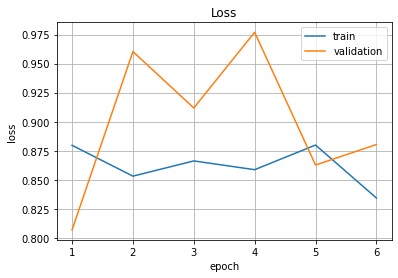

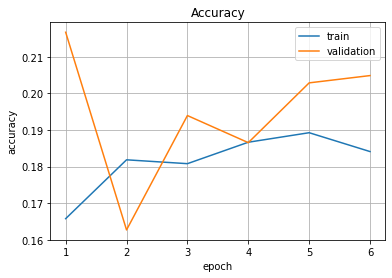

In [66]:
plot_results(results_dir)

#####Testing

In [72]:
generate_predictions(input_test, target_test, input_encoder, output_encoder, checkpoint_dir, x_max_length, y_max_length)

32
85
['join', 'entrepreneur', '.', 'people_id', 'people', '.', 'people_id']
baseline model prediction: ['scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', '<eos>']
model prediction: ['aggregate', 'scan', 'scan', 'scan', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

(<tf.Tensor: shape=(), dtype=float32, numpy=0.22656639>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.30035812>)

####3rd Experiment

#####Data preparation

In [ ]:
operators_input_encoder = EmbeddingsModel()
operators_input_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_input_encoder')
operators_output_encoder = EmbeddingsModel()
operators_output_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_output_encoder')

In [ ]:
train_encoder_inputs, train_decoder_inputs, train_decoder_targets, val_encoder_inputs, val_decoder_inputs, val_decoder_targets, input_test, target_test, x_max_length, y_max_length = create_glove_datasets(operators_input_corpus, operators_target_input_corpus, operators_target_corpus, operators_input_encoder, operators_output_encoder)

Input shape: (5445,), Target shape: (5445,)
Input train shape: (4900,), target train shape: (4900,), target input train shape: (4900,)
Input test shape: (545,), target test shape: (545,), target input test shape: (545,)
Found 766 unique tokens.
Found 10 unique tokens.
Found 10 unique tokens.
Encoder Input train shape: (3920, 32), Decoder input train shape: (3920, 6), Decoder target train shape: (3920, 6)
Encoder Input validation shape: (980, 32), Decoder validation train shape: (980, 6), Decoder validation train shape: (980, 6)


In [ ]:
input_counts, target_counts, count_per_complexity = split_on_length(operators_input_corpus, operators_target_input_corpus)
count_per_complexity

{1: 4784, 2: 554, 3: 93, 4: 10, 5: 4}

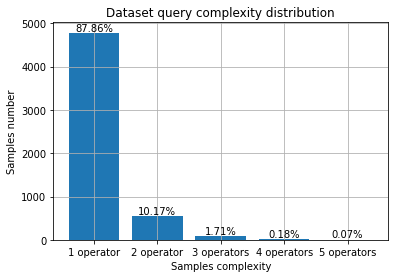

In [ ]:
fig1, ax1 = plt.subplots()
x = [str(i) + (' operator' if i <= 2 else ' operators') for i in count_per_complexity.keys()]
y = [float(i) for i in count_per_complexity.values()]

bar = ax1.bar(x, y, color="C0")

for rect in bar:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2.0, height, "{:.2%}".format(height/sum(count_per_complexity.values())), ha='center', va='bottom')


ax1.grid(which="major", axis="both")
ax1.set_ylabel("Samples number")
ax1.set_xlabel("Samples complexity")
ax1.set_title('Dataset query complexity distribution')


fig1.show()

#####Training

In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/glove/exp_3'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/glove/exp_3/results.pkl"

In [ ]:
glove_operator_encoder, glove_operator_decoder, results = main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               operators_input_encoder, x_max_length, operators_output_encoder, y_max_length, checkpoint_dir, results_dir)

Epochs: 1 batch 0/245 | batch_accuracy: 0.0000 | batch_loss: 0.8243
Epochs: 1 batch 50/245 | batch_accuracy: 0.9375 | batch_loss: 0.1306
Epochs: 1 batch 100/245 | batch_accuracy: 0.6316 | batch_loss: 0.4184
Epochs: 1 batch 150/245 | batch_accuracy: 0.5278 | batch_loss: 0.3590
Epochs: 1 batch 200/245 | batch_accuracy: 1.0000 | batch_loss: 0.1199
Epoch: 1 | Training accuracy over epoch: 0.7729 | Training loss over epoch: 0.3651
Epoch: 1 | Validation acc: 0.9010 | Validation loss: 0.1792
Time taken: 40.21s
Epochs: 2 batch 0/245 | batch_accuracy: 0.9688 | batch_loss: 0.1451
Epochs: 2 batch 50/245 | batch_accuracy: 0.9697 | batch_loss: 0.0873
Epochs: 2 batch 100/245 | batch_accuracy: 0.8824 | batch_loss: 0.2371
Epochs: 2 batch 150/245 | batch_accuracy: 0.9118 | batch_loss: 0.1242
Epochs: 2 batch 200/245 | batch_accuracy: 0.8235 | batch_loss: 0.1536
Epoch: 2 | Training accuracy over epoch: 0.9028 | Training loss over epoch: 0.1459
Epoch: 2 | Validation acc: 0.9004 | Validation loss: 0.1308
T

In [ ]:
glove_operator_encoder.summary()

Model: "encoder_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    multiple                  98176     
                                                                 
 lstm_20 (LSTM)              multiple                  4722688   
                                                                 
Total params: 4,820,864
Trainable params: 4,722,688
Non-trainable params: 98,176
_________________________________________________________________


In [ ]:
glove_operator_decoder.summary()

Model: "decoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 luong_attention_2 (LuongAtt  multiple                 1049600   
 ention)                                                         
                                                                 
 embedding_5 (Embedding)     multiple                  1408      
                                                                 
 lstm_5 (LSTM)               multiple                  4722688   
                                                                 
 dense_7 (Dense)             multiple                  2098176   
                                                                 
 dense_8 (Dense)             multiple                  11275     
                                                                 
Total params: 7,883,147
Trainable params: 7,881,739
Non-trainable params: 1,408
___________________________________________

##### Results

Total training time: 320.96s
Average time per epoch: 40.12s


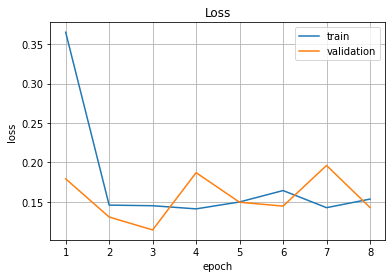

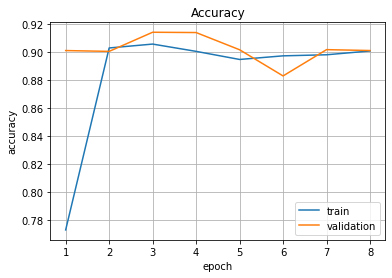

In [ ]:
plot_results(results_dir)

#####Testing

In [ ]:
input_counts, target_counts, count_per_complexity = split_on_length(input_test, target_test)
count_per_complexity

{1: 480, 2: 55, 3: 10}

In [ ]:
bsl_test_acc = {}
test_acc = {}
for i in input_counts.keys():
  bsl_test_acc[i], test_acc[i] = generate_predictions(input_counts[i], target_counts[i], operators_input_encoder, operators_output_encoder, checkpoint_dir, x_max_length, y_max_length)

32
6
['scan', 'festival_detail']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['join', 'assets', '.', 'asset_id', 'fault_log', '.', 'asset_id']
baseline model prediction: ['seq_scan', 'seq_scan', '<eos>']
model prediction: ['hash_join', 'seq_scan', '<eos>']
actual: ['hash_join', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.0

['scan', 'shop']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'captain']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'railway']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Bas

In [ ]:
bsl_total_acc, total_acc = generate_predictions(input_test, target_test, operators_input_encoder, operators_output_encoder, checkpoint_dir, x_max_length, y_max_length)

32
6
['scan', 'festival_detail']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['join', 'assets', '.', 'asset_id', 'fault_log', '.', 'asset_id']
baseline model prediction: ['seq_scan', 'seq_scan', '<eos>']
model prediction: ['hash_join', 'seq_scan', '<eos>']
actual: ['hash_join', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.0

['scan', 'shop']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'captain']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'railway']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Bas

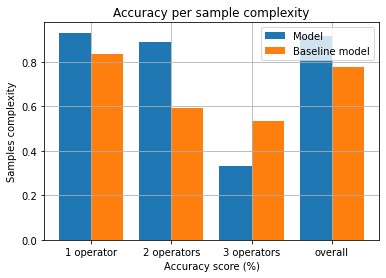

In [ ]:
plot_test_accuracy(bsl_test_acc, bsl_total_acc, test_acc, total_acc)

####4th Experiment

#####Data preparation

In [41]:
ordered_input_encoder = EmbeddingsModel()
ordered_input_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/ordered_input_encoder')
ordered_output_encoder = EmbeddingsModel()
ordered_output_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/ordered_output_encoder')

In [42]:
train_encoder_inputs, train_decoder_inputs, train_decoder_targets, val_encoder_inputs, val_decoder_inputs, val_decoder_targets, input_test, target_test, x_max_length, y_max_length = create_glove_datasets(ordered_input_corpus, ordered_target_input_corpus, ordered_target_corpus, ordered_input_encoder, ordered_output_encoder)

Input shape: (796,), Target shape: (796,)
Input train shape: (716,), target train shape: (716,), target input train shape: (716,)
Input test shape: (80,), target test shape: (80,), target input test shape: (80,)
Found 638 unique tokens.
Found 8 unique tokens.
Found 8 unique tokens.
Encoder Input train shape: (572, 32), Decoder input train shape: (572, 6), Decoder target train shape: (572, 6)
Encoder Input validation shape: (144, 32), Decoder validation train shape: (144, 6), Decoder validation train shape: (144, 6)


In [43]:
input_counts, target_counts, count_per_complexity = split_on_length(ordered_input_corpus, ordered_target_corpus)
count_per_complexity

{2: 599, 3: 167, 4: 24, 5: 6}

#####Training

In [44]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/glove/exp_4'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/glove/exp_4/results.pkl"

In [45]:
encoder, decoder, results = main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               ordered_input_encoder, x_max_length, ordered_output_encoder, y_max_length, checkpoint_dir, results_dir)

Epochs: 1 batch 0/35 | batch_accuracy: 0.2407 | batch_loss: 1.2360
Epoch: 1 | Training accuracy over epoch: 0.5016 | Training loss over epoch: 1.7153
Epoch: 1 | Validation acc: 0.7992 | Validation loss: 0.4982
Time taken: 9.91s
Epochs: 2 batch 0/35 | batch_accuracy: 0.8654 | batch_loss: 0.4464
Epoch: 2 | Training accuracy over epoch: 0.7935 | Training loss over epoch: 0.4358
Epoch: 2 | Validation acc: 0.7976 | Validation loss: 0.4615
Time taken: 4.12s
Epochs: 3 batch 0/35 | batch_accuracy: 0.7593 | batch_loss: 0.4992
Epoch: 3 | Training accuracy over epoch: 0.7828 | Training loss over epoch: 0.4270
Epoch: 3 | Validation acc: 0.7966 | Validation loss: 0.4688
Time taken: 4.09s
Epochs: 4 batch 0/35 | batch_accuracy: 0.8654 | batch_loss: 0.2949
Epoch: 4 | Training accuracy over epoch: 0.7902 | Training loss over epoch: 0.4249
Epoch: 4 | Validation acc: 0.7960 | Validation loss: 0.4629
Time taken: 4.12s
Epochs: 5 batch 0/35 | batch_accuracy: 0.8462 | batch_loss: 0.3358
Epoch: 5 | Training a

In [46]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  81792     
                                                                 
 lstm (LSTM)                 multiple                  4722688   
                                                                 
Total params: 4,804,480
Trainable params: 4,722,688
Non-trainable params: 81,792
_________________________________________________________________


In [47]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 luong_attention (LuongAtten  multiple                 1049600   
 tion)                                                           
                                                                 
 embedding_1 (Embedding)     multiple                  1152      
                                                                 
 lstm_1 (LSTM)               multiple                  4722688   
                                                                 
 dense_1 (Dense)             multiple                  2098176   
                                                                 
 dense_2 (Dense)             multiple                  9225      
                                                                 
Total params: 7,880,841
Trainable params: 7,879,689
Non-trainable params: 1,152
_____________________________________________

#####Results

Total training time: 46.44s
Average time per epoch: 4.64s


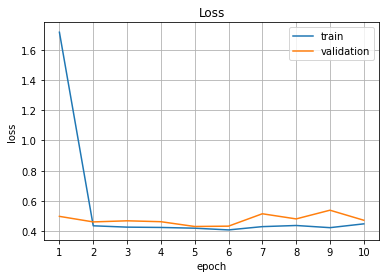

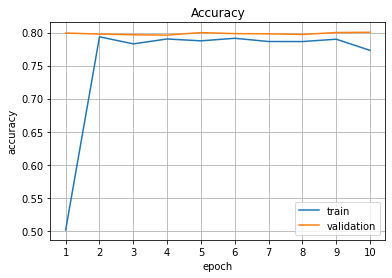

In [48]:
plot_results(results_dir)

#####Testing

In [49]:
input_counts, target_counts, count_per_complexity = split_on_length(input_test, target_test)
count_per_complexity

{2: 61, 3: 17, 4: 2}

In [51]:
bsl_test_acc = {}
test_acc = {}
for i in input_counts.keys():
  bsl_test_acc[i], test_acc[i] = generate_predictions(input_counts[i], target_counts[i], ordered_input_encoder, ordered_output_encoder, checkpoint_dir, x_max_length, y_max_length)

32
6
['join_1', 'election', '.', 'party', 'party', '.', 'party_id', 'scan_1', 'party', '.', 'party']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'apartment_facilities', '.', 'apt_id', 'apartments', '.', 'apt_id', 'scan_1', 'apartments', '.', 'bedroom_count']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'departments', '.', 'dept_store_id', 'department_stores', '.', 'dept_store_id', 'scan_1', 'departments', '.', 'department_name']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'visitors', '.', 'tourist_id', 'visits', '.'

In [52]:
bsl_total_acc, total_acc = generate_predictions(input_test, target_test, ordered_input_encoder, ordered_output_encoder, checkpoint_dir, x_max_length, y_max_length)

32
6
['join_1', 'election', '.', 'party', 'party', '.', 'party_id', 'scan_1', 'party', '.', 'party']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'apartment_facilities', '.', 'apt_id', 'apartments', '.', 'apt_id', 'scan_1', 'apartments', '.', 'bedroom_count']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'student', '.', 'stuid', 'has_pet', '.', 'stuid', 'join_2', 'pets', '.', 'petid', 'has_pet', '.', 'petid', 'scan_1', 'pets', '.', 'pettype']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_2', 'join_1', '<eos>']
Model Accuracy: 0.3333333432674408
Baseline model Accuracy: 0.0

['join_1', 'depart

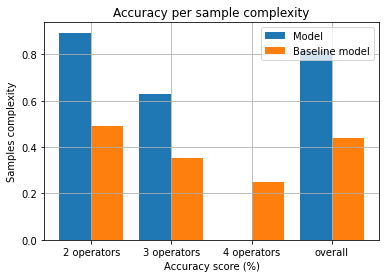

In [71]:
plot_test_accuracy(bsl_test_acc, bsl_total_acc, test_acc, total_acc)

### BoW Experiments

#### 3rd Experiment

In [ ]:
train_encoder_inputs, train_decoder_inputs, train_decoder_targets, val_encoder_inputs, val_decoder_inputs, val_decoder_targets, input_test, target_test, x_max_length, y_max_length, input_tokenizer, idx2word_input, output_tokenizer, idx2word_output = create_bow_datasets(operators_input_corpus, operators_target_input_corpus, operators_target_corpus)

Input shape: (5445,), Target shape: (5445,)
Input train shape: (4900,), target train shape: (4900,), target input train shape: (4900,)
Input test shape: (545,), target test shape: (545,), target input test shape: (545,)
Max Input Length:  32
Found 757 unique input tokens.
padded sequences shape: (4900, 32)
Max Input Length:  6
Found 11 unique input tokens.
padded sequences shape: (4900, 6)
Encoder Input train shape: (3920, 32), Decoder input train shape: (3920, 6), Decoder target train shape: (3920, 6)
Encoder Input validation shape: (980, 32), Decoder validation train shape: (980, 6), Decoder validation train shape: (980, 6)


##### Training

In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/bow/exp_3'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/bow/exp_3/results-v2.pkl"

In [ ]:
encoder, decoder, results = main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               input_tokenizer, x_max_length, output_tokenizer, y_max_length, checkpoint_dir, results_dir, False, idx2word_input, idx2word_output)

Epochs: 1 batch 0/245 | batch_accuracy: 0.0312 | batch_loss: 0.7999
Epochs: 1 batch 50/245 | batch_accuracy: 0.8529 | batch_loss: 0.2733
Epochs: 1 batch 100/245 | batch_accuracy: 0.9706 | batch_loss: 0.0712
Epochs: 1 batch 150/245 | batch_accuracy: 0.8649 | batch_loss: 0.2172
Epochs: 1 batch 200/245 | batch_accuracy: 0.9697 | batch_loss: 0.0210
Epoch: 1 | Training accuracy over epoch: 0.8671 | Training loss over epoch: 0.2185
Epoch: 1 | Validation acc: 0.9123 | Validation loss: 0.1256
Time taken: 41.32s
Epochs: 2 batch 0/245 | batch_accuracy: 1.0000 | batch_loss: 0.0116
Epochs: 2 batch 50/245 | batch_accuracy: 0.8286 | batch_loss: 0.1102
Epochs: 2 batch 100/245 | batch_accuracy: 0.8000 | batch_loss: 0.3975
Epochs: 2 batch 150/245 | batch_accuracy: 0.9167 | batch_loss: 0.1226
Epochs: 2 batch 200/245 | batch_accuracy: 0.9118 | batch_loss: 0.1565
Epoch: 2 | Training accuracy over epoch: 0.9016 | Training loss over epoch: 0.1404
Epoch: 2 | Validation acc: 0.8951 | Validation loss: 0.1474
T

In [ ]:
encoder.summary()

Model: "encoder_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    multiple                  96896     
                                                                 
 lstm_24 (LSTM)              multiple                  4722688   
                                                                 
Total params: 4,819,584
Trainable params: 4,819,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "decoder_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 luong_attention_12 (LuongAt  multiple                 1049600   
 tention)                                                        
                                                                 
 embedding_25 (Embedding)    multiple                  1408      
                                                                 
 lstm_25 (LSTM)              multiple                  4722688   
                                                                 
 dense_37 (Dense)            multiple                  2098176   
                                                                 
 dense_38 (Dense)            multiple                  11275     
                                                                 
Total params: 7,883,147
Trainable params: 7,883,147
Non-trainable params: 0
______________________________________________

##### Results

Total training time: 659.48s
Average time per epoch: 41.22s


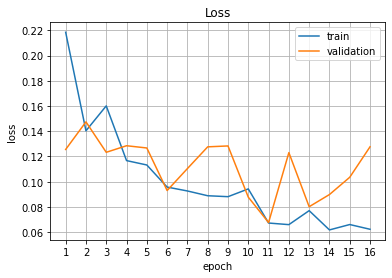

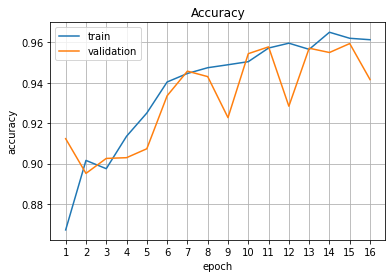

In [ ]:
plot_results(results_dir)

##### Predict

In [ ]:
input_counts, target_counts, count_per_complexity = split_on_length(input_test, target_test)
count_per_complexity

{1: 480, 2: 55, 3: 10}

In [ ]:
bsl_test_acc = {}
test_acc = {}
for i in input_counts.keys():
  bsl_test_acc[i], test_acc[i] = generate_predictions(input_counts[i], target_counts[i], input_tokenizer, output_tokenizer, checkpoint_dir, x_max_length, y_max_length, idx2word_input, idx2word_output, False)

32
6
['scan', 'festival_detail']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['join', 'assets', '.', 'asset_id', 'fault_log', '.', 'asset_id']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['hash_join', '<eos>']
actual: ['hash_join', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.0

['scan', 'shop']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'captain']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'railway']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.

In [ ]:
bsl_total_acc, total_acc = generate_predictions(input_test, target_test, input_tokenizer, output_tokenizer, checkpoint_dir, x_max_length, y_max_length, idx2word_input, idx2word_output, False)

32
6
['scan', 'festival_detail']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['join', 'assets', '.', 'asset_id', 'fault_log', '.', 'asset_id']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['hash_join', '<eos>']
actual: ['hash_join', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.0

['scan', 'shop']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'captain']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.0

['scan', 'railway']
baseline model prediction: ['seq_scan', '<eos>']
model prediction: ['seq_scan', '<eos>']
actual: ['seq_scan', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 1.

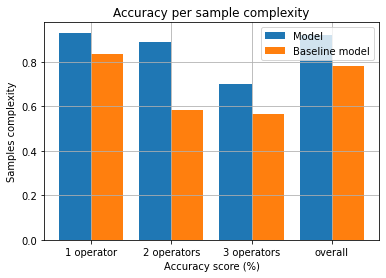

In [ ]:
plot_test_accuracy(bsl_test_acc, bsl_total_acc, test_acc, total_acc)

####4th Experiment

In [73]:
train_encoder_inputs, train_decoder_inputs, train_decoder_targets, val_encoder_inputs, val_decoder_inputs, val_decoder_targets, input_test, target_test, x_max_length, y_max_length, input_tokenizer, idx2word_input, output_tokenizer, idx2word_output = create_bow_datasets(ordered_input_corpus, ordered_target_input_corpus, ordered_target_corpus)

Input shape: (796,), Target shape: (796,)
Input train shape: (716,), target train shape: (716,), target input train shape: (716,)
Input test shape: (80,), target test shape: (80,), target input test shape: (80,)
Max Input Length:  32
Found 629 unique input tokens.
padded sequences shape: (716, 32)
Max Input Length:  6
Found 9 unique input tokens.
padded sequences shape: (716, 6)
Encoder Input train shape: (572, 32), Decoder input train shape: (572, 6), Decoder target train shape: (572, 6)
Encoder Input validation shape: (144, 32), Decoder validation train shape: (144, 6), Decoder validation train shape: (144, 6)


##### Training

In [74]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/bow/exp_4'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/bow/exp_4/results-v2.pkl"

In [56]:
encoder, decoder, results = main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               input_tokenizer, x_max_length, output_tokenizer, y_max_length, checkpoint_dir, results_dir, False, idx2word_input, idx2word_output)

Epochs: 1 batch 0/35 | batch_accuracy: 0.0189 | batch_loss: 1.2129
Epoch: 1 | Training accuracy over epoch: 0.5838 | Training loss over epoch: 1.4223
Epoch: 1 | Validation acc: 0.8068 | Validation loss: 0.5404
Time taken: 4.60s
Epochs: 2 batch 0/35 | batch_accuracy: 0.9020 | batch_loss: 0.2545
Epoch: 2 | Training accuracy over epoch: 0.8441 | Training loss over epoch: 0.3498
Epoch: 2 | Validation acc: 0.8485 | Validation loss: 0.3453
Time taken: 4.30s
Epochs: 3 batch 0/35 | batch_accuracy: 0.8679 | batch_loss: 0.2766
Epoch: 3 | Training accuracy over epoch: 0.8699 | Training loss over epoch: 0.2701
Epoch: 3 | Validation acc: 0.8715 | Validation loss: 0.2730
Time taken: 4.32s
Epochs: 4 batch 0/35 | batch_accuracy: 0.8704 | batch_loss: 0.3129
Epoch: 4 | Training accuracy over epoch: 0.8975 | Training loss over epoch: 0.2075
Epoch: 4 | Validation acc: 0.8797 | Validation loss: 0.2866
Time taken: 4.34s
Epochs: 5 batch 0/35 | batch_accuracy: 0.9608 | batch_loss: 0.0891
Epoch: 5 | Training a

##### Results

Total training time: 47.62s
Average time per epoch: 4.33s


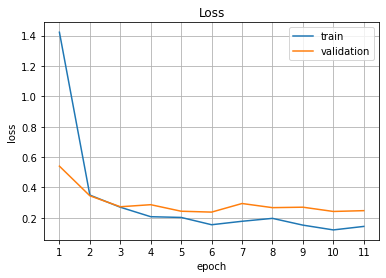

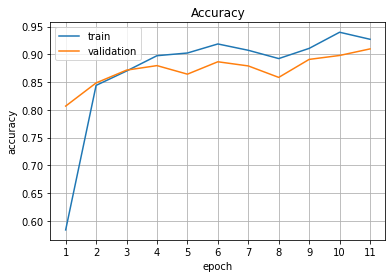

In [57]:
plot_results(results_dir)

##### Testing

In [75]:
input_counts, target_counts, count_per_complexity = split_on_length(input_test, target_test)
count_per_complexity

{2: 61, 3: 17, 4: 2}

In [76]:
bsl_test_acc = {}
test_acc = {}
for i in input_counts.keys():
  bsl_test_acc[i], test_acc[i] = generate_predictions(input_counts[i], target_counts[i], input_tokenizer, output_tokenizer, checkpoint_dir, x_max_length, y_max_length, idx2word_input, idx2word_output, False)

32
6
['join_1', 'election', '.', 'party', 'party', '.', 'party_id', 'scan_1', 'party', '.', 'party']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'apartment_facilities', '.', 'apt_id', 'apartments', '.', 'apt_id', 'scan_1', 'apartments', '.', 'bedroom_count']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'departments', '.', 'dept_store_id', 'department_stores', '.', 'dept_store_id', 'scan_1', 'departments', '.', 'department_name']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'visitors', '.', 'tourist_id', 'visits', '.'

In [77]:
bsl_total_acc, total_acc = generate_predictions(input_test, target_test, input_tokenizer, output_tokenizer, checkpoint_dir, x_max_length, y_max_length, idx2word_input, idx2word_output, False)

32
6
['join_1', 'election', '.', 'party', 'party', '.', 'party_id', 'scan_1', 'party', '.', 'party']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'apartment_facilities', '.', 'apt_id', 'apartments', '.', 'apt_id', 'scan_1', 'apartments', '.', 'bedroom_count']
baseline model prediction: ['join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_1', '<eos>']
actual: ['scan_1', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.5

['join_1', 'student', '.', 'stuid', 'has_pet', '.', 'stuid', 'join_2', 'pets', '.', 'petid', 'has_pet', '.', 'petid', 'scan_1', 'pets', '.', 'pettype']
baseline model prediction: ['join_1', 'join_1', 'join_1', '<eos>']
model prediction: ['scan_1', 'join_2', 'join_1', '<eos>']
actual: ['scan_1', 'join_2', 'join_1', '<eos>']
Model Accuracy: 1.0
Baseline model Accuracy: 0.3333333432674408

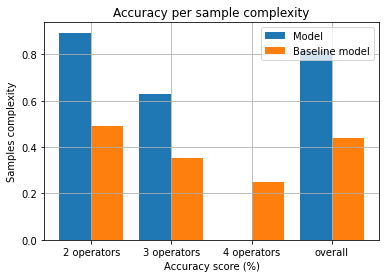

In [78]:
plot_test_accuracy(bsl_test_acc, bsl_total_acc, test_acc, total_acc)